# Demo: Reading a short-ranged prediction
- The national water model outputs many .nc files in their AWS bucket
- This tutorial is meant to show how to batch speficic forecasts and variables from many NC files in one xarray object rather than reading everything to disk one by one

![The example of the NWM Bucket](../docs/img/bucket.png)
This is an example of the bucket and how there are 1,700 .nc files generated for *just* the short ranged forecast @ https://noaa-nwm-pds.s3.amazonaws.com/index.html

### How to set up this tutorial/notebook

1. Install a python env `uv venv`
2. Install the nwm_batcher package through `uv pip install -e .` from the project root

In [ ]:
import nwm_batcher
import xarray as xr

In [14]:
virtual_datasets = nwm_batcher.read(
    date="20250516",
    forecast_type="short_range",
    initial_time="t00z",
    variable="land",
    data_variable="ACCET",
    coordinates=["time", "reference_time", "x", "y"]
)
virtual_datasets[0]

<xarray.Dataset> Size: 849MB
Dimensions:         (time: 1, y: 3840, x: 4608, reference_time: 1)
Coordinates:
    time            (time) int32 4B ManifestArray<shape=(1,), dtype=int32, ch...
    reference_time  (reference_time) int32 4B ManifestArray<shape=(1,), dtype...
    x               (x) float64 37kB ManifestArray<shape=(4608,), dtype=float...
    y               (y) float64 31kB ManifestArray<shape=(3840,), dtype=float...
Data variables:
    SNOWH           (time, y, x) float64 142MB ManifestArray<shape=(1, 3840, ...
    SNEQV           (time, y, x) float64 142MB ManifestArray<shape=(1, 3840, ...
    FSNO            (time, y, x) float64 142MB ManifestArray<shape=(1, 3840, ...
    ACCET           (time, y, x) float64 142MB ManifestArray<shape=(1, 3840, ...
    SOILSAT_TOP     (time, y, x) float64 142MB ManifestArray<shape=(1, 3840, ...
    SNOWT_AVG       (time, y, x) float64 142MB ManifestArray<shape=(1, 3840, ...
Attributes:
    TITLE:                      OUTPUT FROM NWM v3.0
    model_initialization_time:  2025-05-16_00:00:00
    model_output_valid_time:    2025-05-16_01:00:00
    model_total_valid_times:    18
    Conventions:                CF-1.6
    code_version:               v5.3.0-alpha1
    NWM_version_number:         v3.0
    model_output_type:          land
    model_configuration:        short_range
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    GDAL_DataType:              Generic

In [15]:
virtual_datasets[0].virtualize.to_kerchunk("NWM_ACCET.json", format="json")

In [16]:
import fsspec
import s3fs
import os

os.environ['AWS_REGION'] = 'us-east-1'
fs = s3fs.S3FileSystem(anon=True, client_kwargs={'region_name': 'us-east-1'})

/home/tbindas/tbindas/.conda/envs/nwm_batcher/lib/python3.12/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'SNOWH' has multiple fill values {np.int64(-99990000), np.float64(0.0)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/tbindas/tbindas/.conda/envs/nwm_batcher/lib/python3.12/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'SNEQV' has multiple fill values {np.float64(0.0), np.int64(-99990)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/tbindas/tbindas/.conda/envs/nwm_batcher/lib/python3.12/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'FSNO' has multiple fill values {np.int64(-9999000), np.float64(0.0)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/tbindas/tbindas/.conda/envs/nwm_batcher/lib/python3.12/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'ACCET' has multiple fill values {n

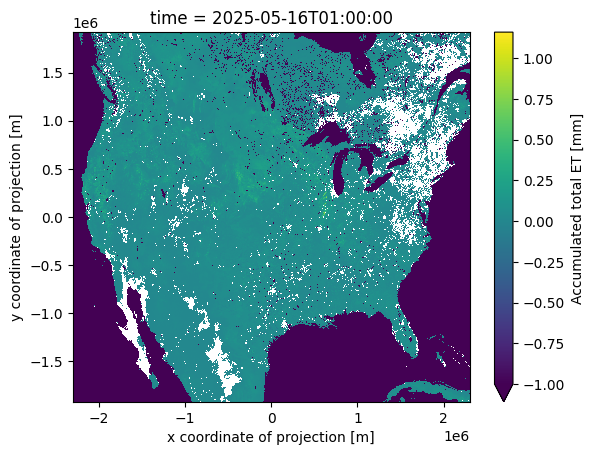

In [22]:
storage_options = dict(
    remote_protocol="s3", remote_options=dict(anon=True)
)
ds = xr.open_dataset(
    "NWM_ACCET.json",
    engine="kerchunk",
    backend_kwargs={"storage_options": storage_options},
)
ds.ACCET.plot(vmin=-1, vmax=ds.ACCET.max().values)